In [99]:
import numpy as np
import kagglehub
import os
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV, ElasticNetCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif, RFE
import shap

In [100]:
path = kagglehub.dataset_download("gauravduttakiit/mobile-price-classification")

df = pd.read_csv(os.path.join( path, os.listdir(path)[-1]))
scaler = MinMaxScaler()

columns_to_scale = df.columns.difference(["price_range"])
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
print(df.shape)
df.head()

(2000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,0.227789,0.0,0.68,0.0,0.052632,0.0,0.080645,0.555556,0.900000,0.142857,...,0.010204,0.170895,0.612774,0.285714,0.388889,0.944444,0.0,0.0,1.0,1
1,0.347361,1.0,0.00,1.0,0.000000,1.0,0.822581,0.666667,0.466667,0.285714,...,0.461735,0.993324,0.634687,0.857143,0.166667,0.277778,1.0,1.0,0.0,2
2,0.041416,1.0,0.00,1.0,0.105263,1.0,0.629032,0.888889,0.541667,0.571429,...,0.644388,0.811749,0.627205,0.428571,0.111111,0.388889,1.0,1.0,0.0,2
3,0.076152,1.0,0.80,0.0,0.000000,0.0,0.129032,0.777778,0.425000,0.714286,...,0.620408,0.858478,0.671566,0.785714,0.444444,0.500000,1.0,0.0,0.0,2
4,0.881764,1.0,0.28,0.0,0.684211,1.0,0.677419,0.555556,0.508333,0.142857,...,0.616327,0.475300,0.308658,0.214286,0.111111,0.722222,1.0,1.0,0.0,1


In [76]:
df.isna().sum().any()

False

In [77]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [78]:
df.std()

battery_power    0.293533
blue             0.500100
clock_speed      0.326402
dual_sim         0.500035
fc               0.228497
four_g           0.499662
int_memory       0.292673
m_dep            0.320462
mobile_wt        0.294997
n_cores          0.326834
pc               0.303216
px_height        0.226419
px_width         0.288518
ram              0.289880
sc_h             0.300946
sc_w             0.242022
talk_time        0.303553
three_g          0.426273
touch_screen     0.500116
wifi             0.500076
price_range      1.118314
dtype: float64

In [79]:
df.var()

battery_power    0.086161
blue             0.250100
clock_speed      0.106538
dual_sim         0.250035
fc               0.052211
four_g           0.249663
int_memory       0.085657
m_dep            0.102696
mobile_wt        0.087023
n_cores          0.106820
pc               0.091940
px_height        0.051265
px_width         0.083242
ram              0.084031
sc_h             0.090569
sc_w             0.058575
talk_time        0.092144
three_g          0.181709
touch_screen     0.250116
wifi             0.250076
price_range      1.250625
dtype: float64

In [80]:
df[df.var().sort_values(ascending=False)[:4].index]

,price_range,touch_screen,blue,wifi
0,1,0.0,0.0,1.0
1,2,1.0,1.0,0.0
2,2,1.0,1.0,0.0
3,2,0.0,1.0,0.0
4,1,1.0,1.0,0.0
...,...,...,...,...
1995,0,1.0,1.0,0.0
1996,2,1.0,1.0,1.0
1997,3,1.0,0.0,0.0
1998,0,1.0,0.0,1.0


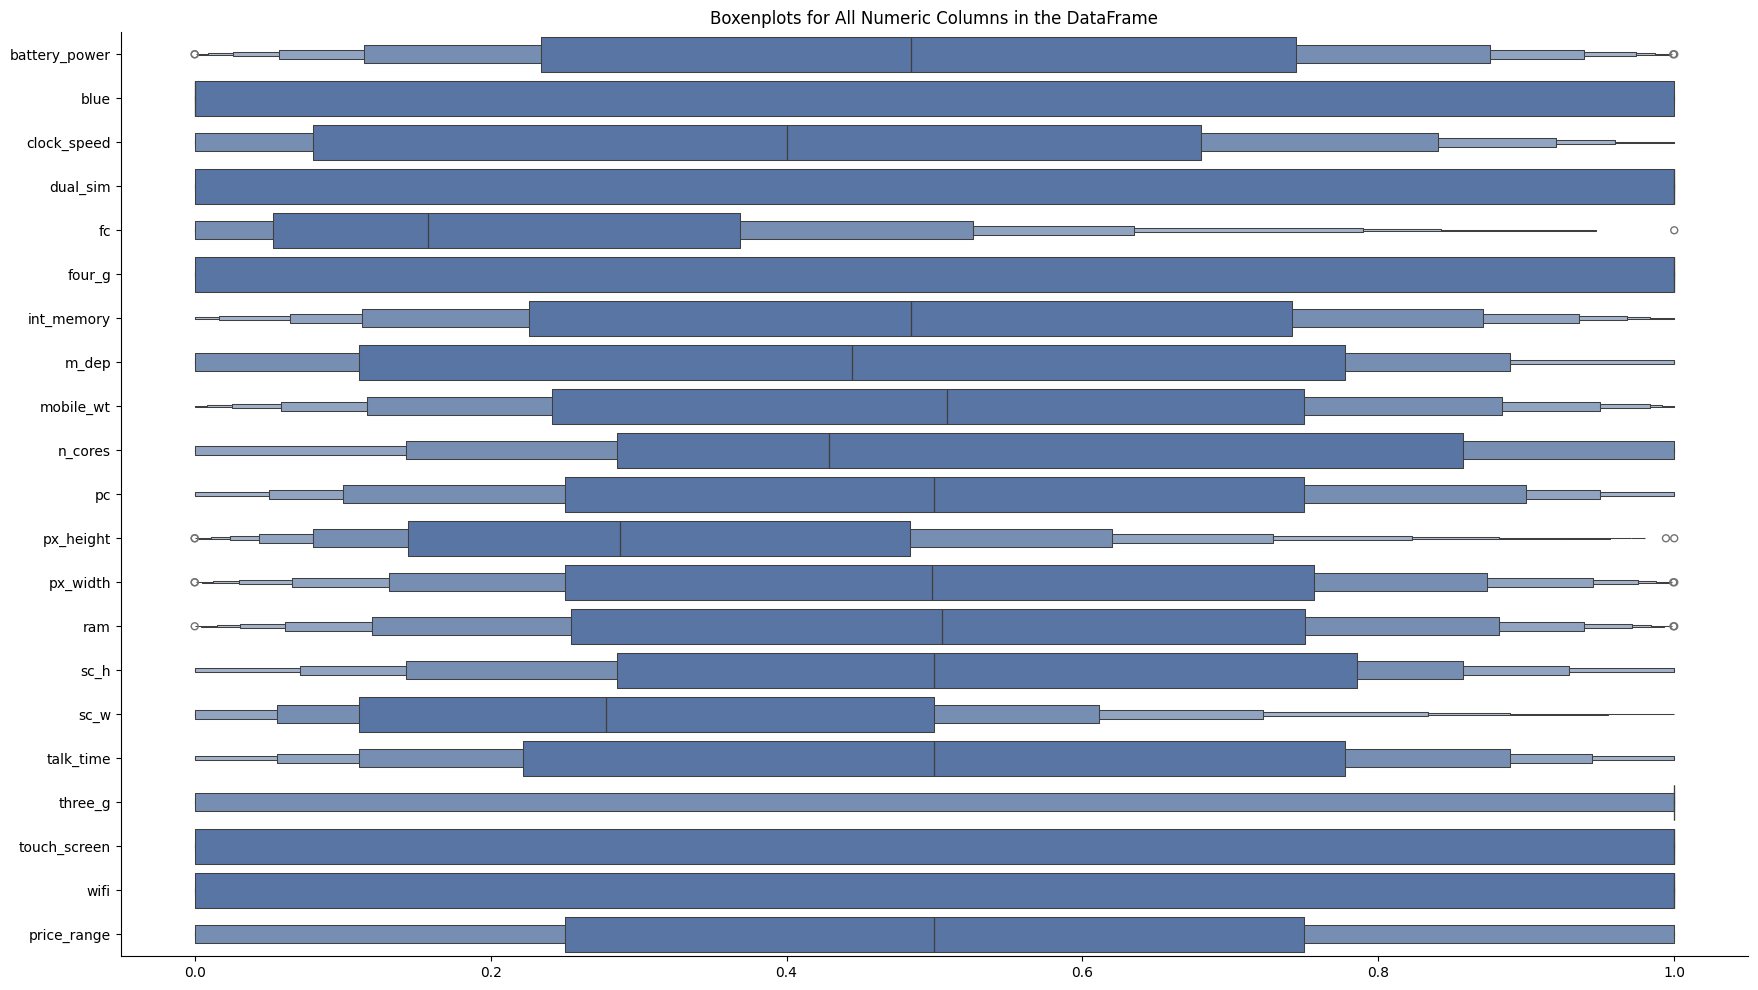

In [47]:
def plot_all_boxenplots(df):
    num_columns = df.select_dtypes(include=['number']).shape[1]
    plt.figure(figsize=(num_columns, 12))
    sns.boxenplot(data=df.select_dtypes(include=['number']), orient='h', color=sns.color_palette("deep")[0], k_depth="trustworthy")
    plt.title('Boxenplots for All Numeric Columns in the DataFrame')
    sns.despine()
    plt.show()

plot_all_boxenplots(df)

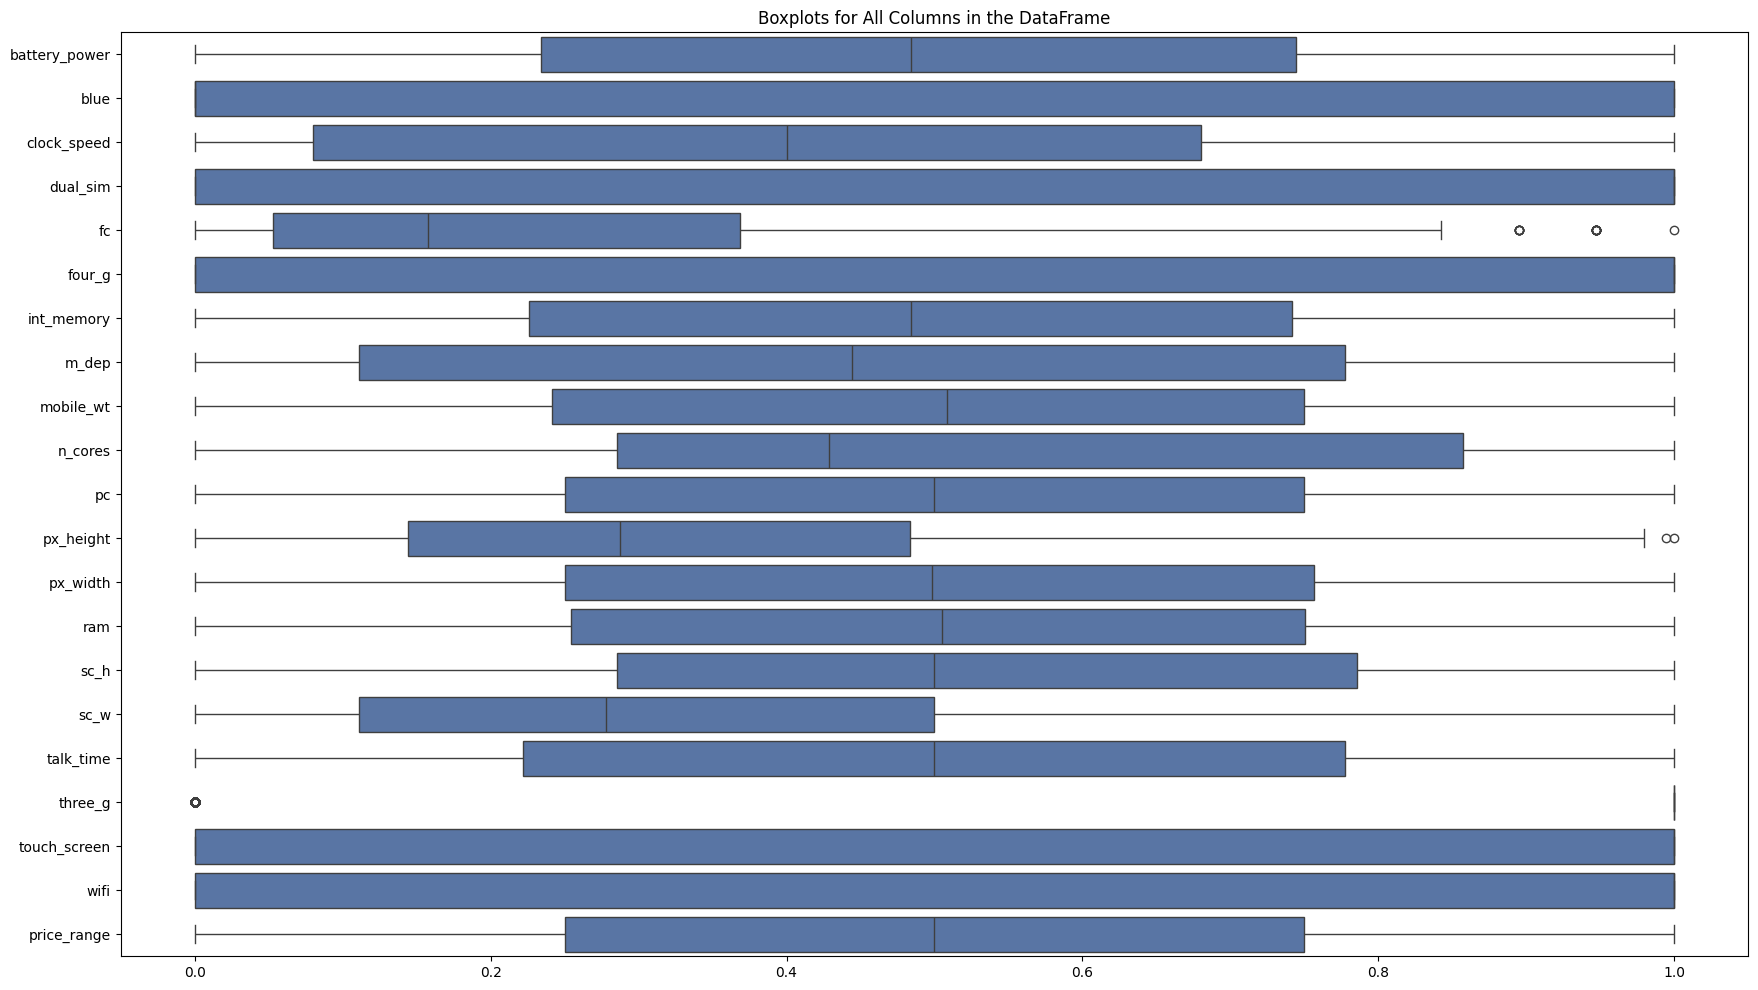

In [45]:
def plot_all_boxplots(df):
    num_columns = df.shape[1]
    plt.figure(figsize=(num_columns , 12))
    sns.boxplot(data=df, orient='h', color=sns.color_palette("deep")[0])
    plt.title('Boxplots for All Columns in the DataFrame')
    plt.show()

# Example usage
# Replace 'df' with your DataFrame
plot_all_boxplots(df)

In [33]:
def detect_outliers_percentile_df(df, lower_percentile=1, upper_percentile=99):
    outliers_list = []
    for column in df.select_dtypes(include=[np.number]).columns:
        lower_bound = np.percentile(df[column], lower_percentile)
        upper_bound = np.percentile(df[column], upper_percentile)
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        for index, value in outliers.items():
            outliers_list.append({'Column': column, 'Index': index, 'Outlier Value': value})
    return pd.DataFrame(outliers_list)

# Example usage
outliers_df = detect_outliers_percentile_df(df)
outliers_df

,Column,Index,Outlier Value
0,battery_power,9,0.005344
1,battery_power,24,0.001336
2,battery_power,149,0.003340
3,battery_power,196,0.993988
4,battery_power,257,0.004008
...,...,...,...
196,sc_w,1254,1.000000
197,sc_w,1420,1.000000
198,sc_w,1645,1.000000
199,sc_w,1807,1.000000


In [36]:
outliers_df.groupby('Column').count().sort_values(by='Index', ascending=False)

,Index,Outlier Value
Column,,
ram,40,40
px_height,39,39
px_width,39,39
battery_power,38,38
mobile_wt,19,19
fc,18,18
sc_w,8,8


In [37]:
def detect_outliers_zscore_df(df, threshold=3):
    outliers_list = []
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    z_scores = df[numeric_columns].apply(zscore)
    
    for column in numeric_columns:
        outliers = df[np.abs(z_scores[column]) > threshold][column]
        for index, value in outliers.items():
            outliers_list.append({'Column': column, 'Index': index, 'Outlier Value': value})
    
    return pd.DataFrame(outliers_list)

# Example usage
outliers_df = detect_outliers_zscore_df(df)
outliers_df

,Column,Index,Outlier Value
0,fc,95,0.947368
1,fc,226,0.947368
2,fc,305,0.947368
3,fc,1387,0.947368
4,fc,1406,0.947368
5,fc,1416,0.947368
6,fc,1554,0.947368
7,fc,1693,0.947368
8,fc,1705,1.000000
9,fc,1880,0.947368


In [ ]:
sns.pairplot(df, hue="price_range", diag_kind="kde")    


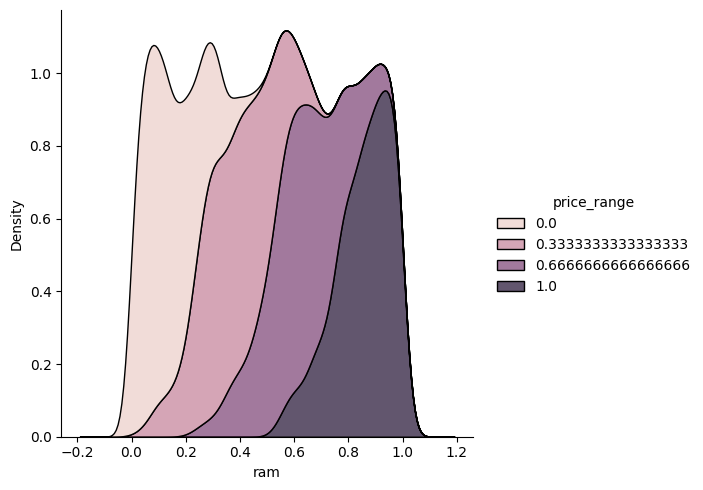

In [51]:
sns.displot(data=df, x="ram", hue="price_range", kind="kde", multiple="stack")

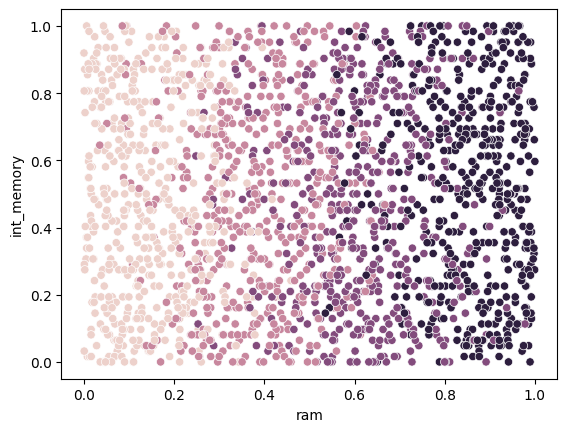

In [54]:
sns.scatterplot(data=df, x="ram", y="int_memory", hue="price_range", legend=False)
plt.show()

In [59]:
df['price_range'].value_counts()

0.333333    500
0.666667    500
1.000000    500
0.000000    500
Name: price_range, dtype: int64

In [17]:
df.var().sort_values(ascending=False)

touch_screen     0.250116
blue             0.250100
wifi             0.250076
dual_sim         0.250035
four_g           0.249663
three_g          0.181709
price_range      0.138958
n_cores          0.106820
clock_speed      0.106538
m_dep            0.102696
talk_time        0.092144
pc               0.091940
sc_h             0.090569
mobile_wt        0.087023
battery_power    0.086161
int_memory       0.085657
ram              0.084031
px_width         0.083242
sc_w             0.058575
fc               0.052211
px_height        0.051265
dtype: float64

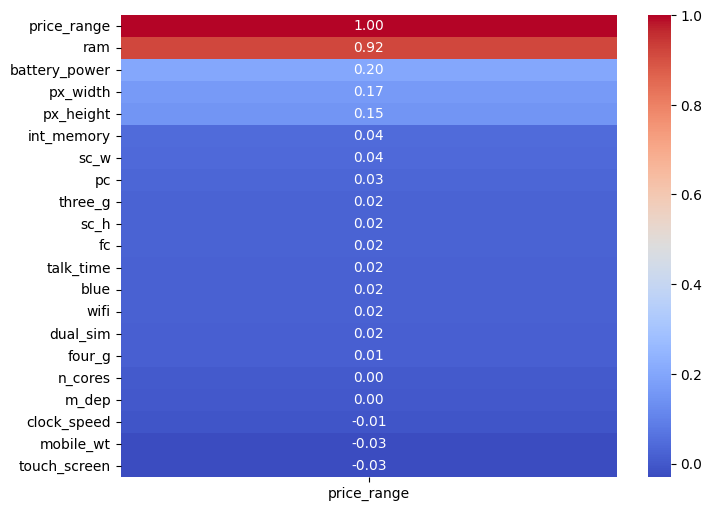

In [12]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix[['price_range']].sort_values(by='price_range', ascending=False), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

plt.show()

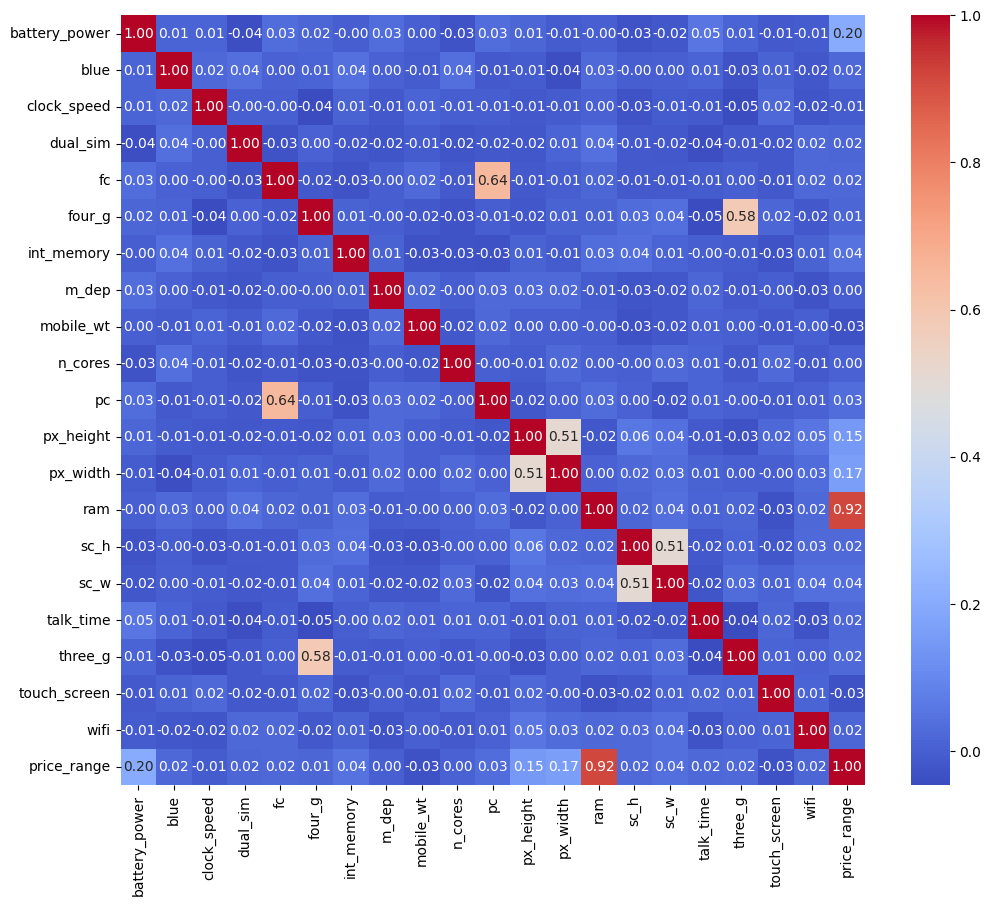

In [13]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

plt.show()

In [15]:
X = df.drop('price_range', axis=1)  # Drop the target variable
X = add_constant(X)  # Add constant for the intercept term

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          feature        VIF
0           const  37.782774
1   battery_power   1.009945
2            blue   1.011342
3     clock_speed   1.006025
4        dual_sim   1.011555
5              fc   1.718987
6          four_g   1.528509
7      int_memory   1.009274
8           m_dep   1.006385
9       mobile_wt   1.004548
10        n_cores   1.008442
11             pc   1.720785
12      px_height   1.369052
13       px_width   1.362399
14            ram   1.008331
15           sc_h   1.356109
16           sc_w   1.353648
17      talk_time   1.010502
18        three_g   1.527367
19   touch_screen   1.006278
20           wifi   1.009100


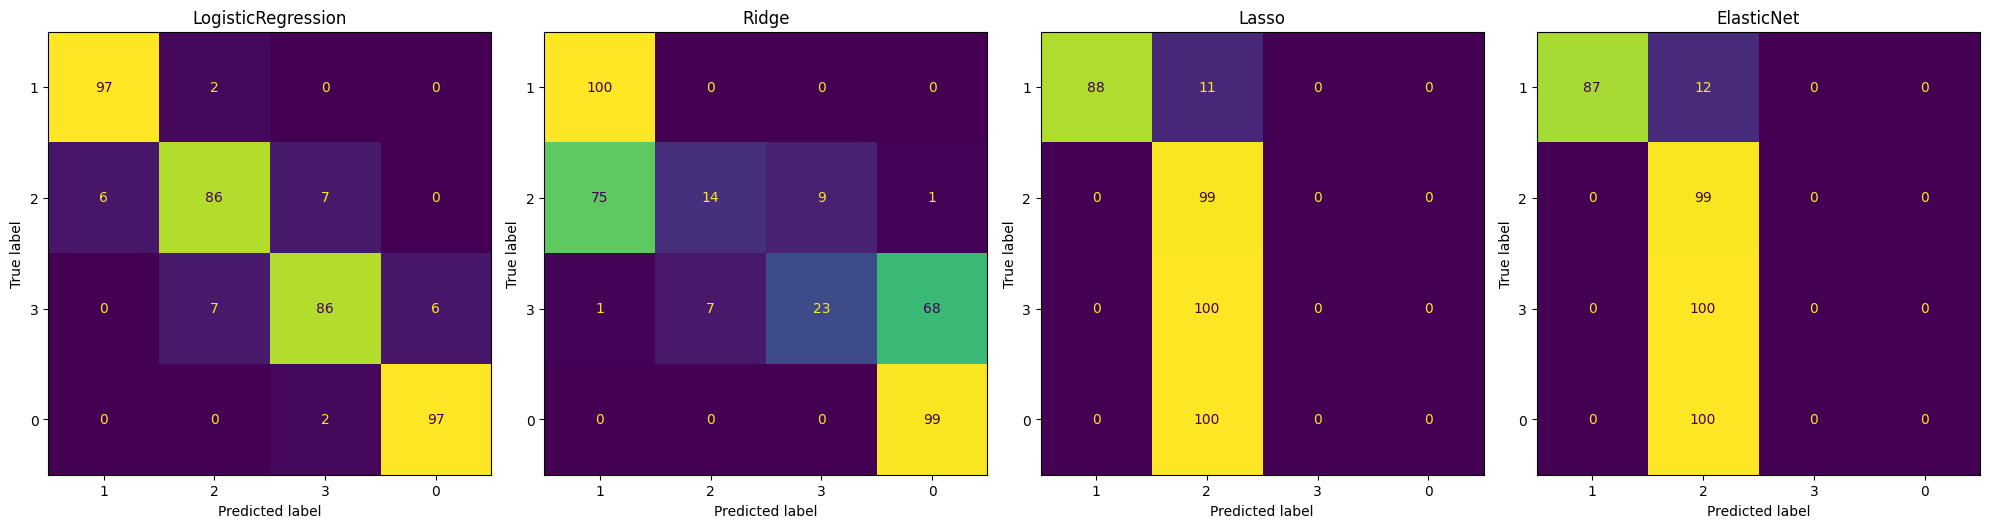

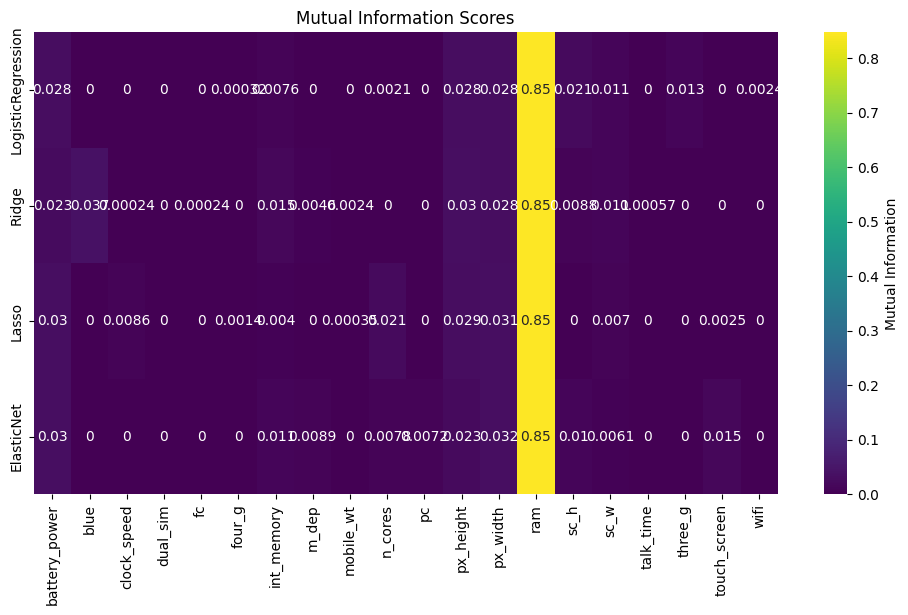

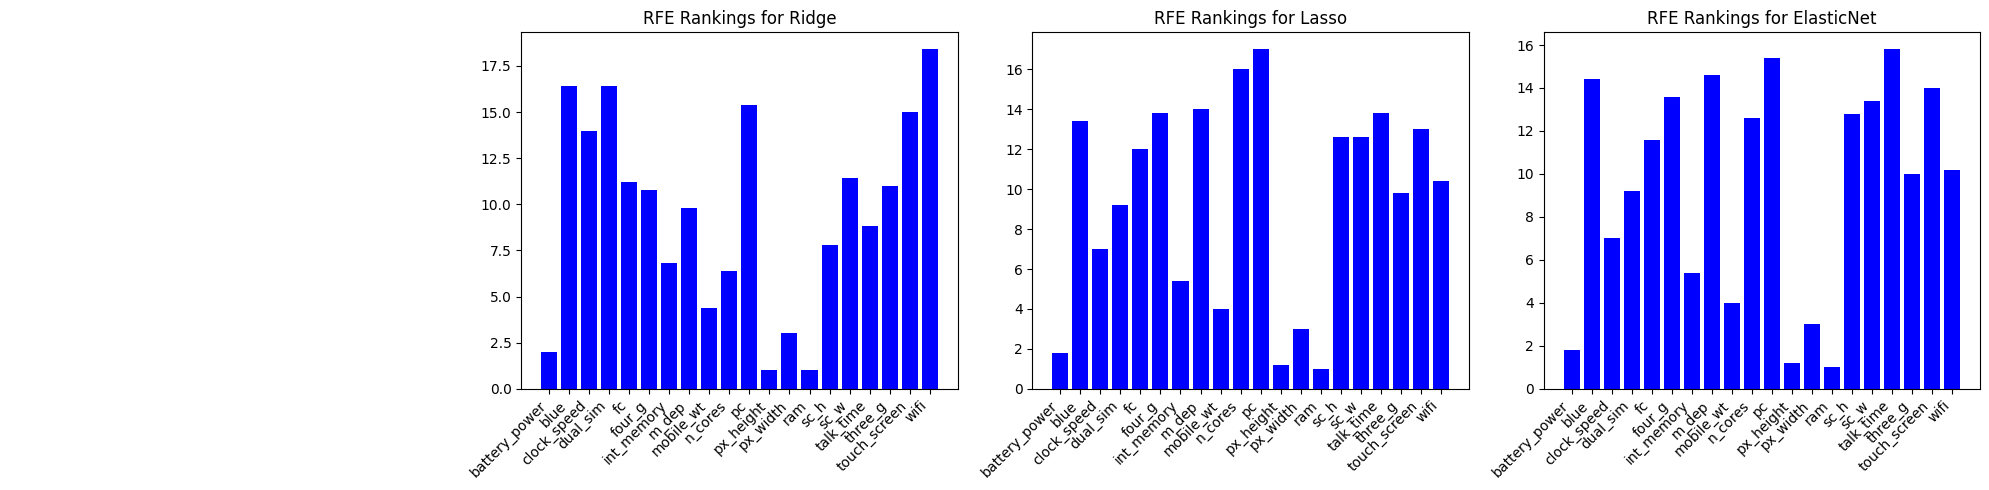

In [104]:
X = df.drop(columns=['price_range'])
y = df['price_range']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'Ridge': RidgeClassifier(random_state=42),
    'Lasso': LassoCV(cv=5, random_state=42),
    'ElasticNet': ElasticNetCV(cv=5, random_state=42)
}

shap_values_all = {}
mutual_info_scores = {}
feature_rankings = {}
conf_matrices = {}

for model_name, model in models.items():
    shap_values_model = []
    conf_matrices[model_name] = []
    feature_rankings[model_name] = []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if model_name in ['Lasso', 'ElasticNet']:
            model.fit(X_train, y_train)
            y_pred = (model.predict(X_test) > 0.5).astype(int)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        conf_matrices[model_name].append(confusion_matrix(y_test, y_pred))

        if model_name not in ['Lasso', 'ElasticNet']:
            explainer = shap.LinearExplainer(model, X_train)
            shap_values = explainer.shap_values(X_test)
            shap_values_model.append(shap_values)

        if model_name != 'LogisticRegression':
            selector = RFE(model, n_features_to_select=2)
            selector.fit(X_train, y_train)
            feature_rankings[model_name].append(selector.ranking_)

    if model_name not in ['Lasso', 'ElasticNet']:
        shap_values_all[model_name] = np.vstack(shap_values_model)

    mutual_info_scores[model_name] = dict(zip(X.columns, mutual_info_classif(X, y)))

# Plot SHAP values side by side


# Plot confusion matrices side by side
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

for idx, (model_name, conf_matrix_list) in enumerate(conf_matrices.items()):
    if len(conf_matrix_list) > 0:
        avg_conf_matrix = np.mean(conf_matrix_list, axis=0).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix, display_labels=y.unique())
        disp.plot(ax=axes[idx], colorbar=False)
        axes[idx].set_title(model_name)
    else:
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot mutual information scores
mutual_info_df = pd.DataFrame(mutual_info_scores).T
mutual_info_df.columns = X.columns
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(mutual_info_df, annot=True, cmap="viridis", ax=ax, cbar_kws={'label': 'Mutual Information'})
plt.title("Mutual Information Scores")
plt.show()

# Plot RFE rankings side by side
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

for idx, (model_name, rankings) in enumerate(feature_rankings.items()):
    if rankings:
        avg_ranking = np.mean(rankings, axis=0)
        axes[idx].bar(X.columns, avg_ranking, color='blue')
        axes[idx].set_title(f"RFE Rankings for {model_name}")
        axes[idx].set_xticks(range(len(X.columns)))
        axes[idx].set_xticklabels(X.columns, rotation=45, ha='right')
    else:
        axes[idx].axis('off')

plt.tight_layout()
plt.show()